In [1]:
#In this part, we will deploy an image classification model in Azure Container Instance (ACI). 
#We are going to begin by setting our environment up by first, installing our needed packages.import

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
import azureml.core

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.26.0


In [2]:
%%writefile score.py

#Now we are going to start deploying our program as a web service hosted in ACL.
#To begin this, we are going to create a file called score.py. In the code, the `init` function is what loads the model into a global object.
#The run(input_data) function uses the model to predict a value based on the input data.

import json
import numpy as np
import os
import pickle
import joblib

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()


Writing score.py


In [3]:
#Next, we create a config file where we specify the number of CPUs and gigabyte of RAM needed.

from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

In [4]:
%%time

'''
Finally, we deploy to ACI.
The following code goes through these steps:

Create environment object containing dependencies needed by the model using the environment file (myenv.yml)
Create inference configuration necessary to deploy the model as a web service using:
    The scoring file (score.py)
    envrionment object created in previous step
Deploy the model to the ACI container.
Get the web service HTTP endpoint.

Time Consuming
'''


import uuid
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')


myenv = Environment.get(workspace=ws, name="tutorial-env", version="1")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

service_name = 'sklearn-mnist-svc-' + str(uuid.uuid4())[:4]
service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-04-14 06:31:47+00:00 Creating Container Registry if not exists.
2021-04-14 06:31:50+00:00 Use the existing image.
2021-04-14 06:31:51+00:00 Generating deployment configuration..
2021-04-14 06:31:53+00:00 Submitting deployment to compute..
2021-04-14 06:31:59+00:00 Checking the status of deployment sklearn-mnist-svc-802d..
2021-04-14 06:32:45+00:00 Checking the status of inference endpoint sklearn-mnist-svc-802d.
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 481 ms, sys: 23.8 ms, total: 505 ms
Wall time: 1min 11s


In [5]:
#This will print out an endpoint allowing anyone to test the web service or integrate it into their own application.

print(service.scoring_uri)

http://897f7544-71b1-443a-b490-f4989273f917.westus.azurecontainer.io/score


In [6]:
#Here, we will start testing our model on real data.
#This code will download the data we will test on.

import os
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/globalainight2021/code/Users/vinayven01/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/globalainight2021/code/Users/vinayven01/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/globalainight2021/code/Users/vinayven01/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/globalainight2021/code/Users/vinayven01/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz']

In [7]:
#Now we are loading the test data that we downloaded in the cell above.

from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

In [8]:
#Now, we are actually applying our data to our trained model to see predictions. All we are doing is sending JSON data to our endpoint.

import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

In [9]:
#We create something called a confusion matrix to visualize our correct and incorrect predictions.

from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


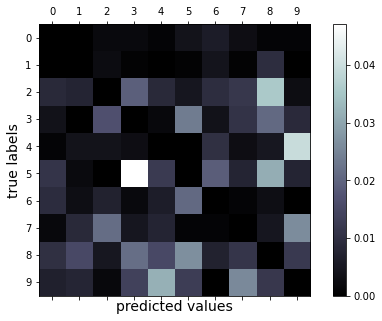

In [10]:
#To display the confusion matrix as a graph so we can visualize it, we use matplotlib

# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

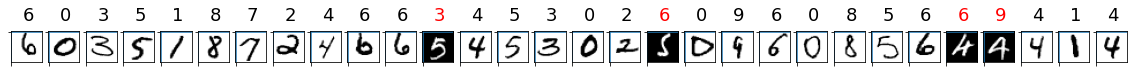

In [11]:
#Here, we show our predictions after testing it on 30 images. It may take a couple tries to find an incorrect prediction due to our models accuracy being high.

import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

In [ ]:
#The End!